# Simple Neural Network Implementation in Python

This notebook implements a basic feedforward neural network from scratch using **NumPy** and **TensorFlow**.  
It includes different layers, activation functions, loss functions, and training routines for the MNIST dataset.



## 1. Imports and Seed Initialization

- `numpy` for numerical computations.
- `tensorflow` for loading the MNIST dataset.
- `matplotlib` for plotting.
- Seeds are set for reproducibility.



In [9]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

seed = 113
np.random.seed(seed)
tf.random.set_seed(seed)

## 2. Base Layer Class

The abstract base class `Layer` defines:

- `forward(x)`: forward propagation  
- `backward(output_error_derivative)`: backward propagation  
- `learning_rate` property with validation

In [10]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) ->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate

## 3. Fully Connected (Dense) Layer

- `input_size` and `output_size` define layer dimensions  
- `init_type`: 0 = Xavier initialization, 1 = He initialization  
- Implements forward and backward propagation

In [11]:
class FullyConnected(Layer):

    def __init__(self, input_size: int, output_size: int, init_type: int) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        if init_type == 0:
          limit = np.sqrt(6 / (input_size + output_size))
        else:
          limit = np.sqrt(2 / input_size)
        self.weights = np.random.uniform(-limit, limit, (input_size, output_size))
        self.biases = np.zeros((1, output_size))

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.inputs = x
        self.outputs = np.dot(self.inputs, self.weights) + self.biases
        return self.outputs

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        weights_errors = np.dot(self.inputs.T, output_error_derivative)
        biases_errors = np.sum(output_error_derivative, axis=0, keepdims=True)
        self.weights -= self.learning_rate * weights_errors
        self.biases -= self.learning_rate * biases_errors
        return np.dot(output_error_derivative, self.weights.T)

## 4. Activation Functions

Implemented activation functions:

- **Tanh**: hyperbolic tangent  
- **ReLU**: rectified linear unit  
- **Sigmoid**: logistic function  
- **Softmax**: for multi-class outputs  

Each implements its own forward and backward derivatives.


In [12]:
class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.inputs = x
        self.outputs = np.tanh(x)
        return self.outputs

    def backward(self, output_error_derivative) -> np.ndarray:
        tanh_derivative = 1 - np.power(self.outputs, 2)
        return output_error_derivative * tanh_derivative

class ReLu(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
      self.inputs = x
      self.outputs = np.maximum(0, x)
      return self.outputs

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
      relu_derivative = np.where(self.inputs > 0, 1, 0)
      return output_error_derivative * relu_derivative

class Sigmoid(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
      self.inputs = x
      self.outputs = 1 / (1 + np.exp(-x))
      return self.outputs

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
      sigmoid_derivative = self.outputs * (1 - self.outputs)
      return output_error_derivative * sigmoid_derivative

class Softmax(Layer):
    def forward(self, x: np.ndarray) -> np.ndarray:
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.outputs = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return self.outputs

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        return output_error_derivative

## 5. Loss Function

The `Loss` class wraps any differentiable loss function.

- `loss(y_pred, y_true)`: compute the loss  
- `loss_derivative(y_pred, y_true)`: derivative for backpropagation

### Cross-Entropy Loss

- Commonly used for classification tasks


In [13]:
class Loss:
    def __init__(self, loss_function: callable, loss_function_derivative: callable) -> None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.loss_function(x, y)

    def loss_derivative(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.loss_function_derivative(x, y)

## 6. Neural Network Class

The `Network` class combines layers into a full model.

Features:

- Handles forward pass and backward pass  
- Weight updates using learning rate  
- `fit()`: train the network  
- `accuracy()`: evaluate predictions


In [14]:
class Network:
    def __init__(self, layers: List[Layer], learning_rate: float) -> None:
        self.layers = layers
        self.learning_rate = learning_rate

    def compile(self, loss: Loss) -> None:
        self.loss = loss

    def __call__(self, x: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def fit(self,
            x_train: np.ndarray,
            y_train: np.ndarray,
            epochs: int,
            learning_rate: float,
            verbose: int = 0) -> None:
        self.learning_rate = learning_rate
        if verbose > 0 and (epochs % verbose == 0):
          self.losses = [0] * (int(epochs/verbose))
          self.epoch_list = [0] * (int(epochs/verbose))
          self.accuracies = [0] * (int(epochs/verbose))
          i = 0
        if learning_rate is not None:
            for layer in self.layers:
                layer.learning_rate = learning_rate
        for epoch in range(epochs):
            epoch_loss = 0
            output = self(x_train)
            loss_value = self.loss.loss(output, y_train)
            epoch_loss += loss_value
            loss_derivative = self.loss.loss_derivative(output, y_train)
            for layer in reversed(self.layers):
                loss_derivative = layer.backward(loss_derivative)

            predicted_classes = np.argmax(output, axis=1)
            true_classes = np.argmax(y_train, axis=1)
            accuracy = np.mean(predicted_classes == true_classes)

            if verbose > 0 and (epoch + 1) % verbose == 0:
                #print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(x_train)}, Accuracy: {accuracy * 100:.2f}%")
                self.losses[i] = epoch_loss / len(x_train)
                self.accuracies[i] = accuracy
                self.epoch_list[i] = epoch+1
                i+=1

    def accuracy(self, x_test: np.ndarray, y_test: np.ndarray) -> float:
        predictions = self(x_test)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(y_test, axis=1)
        accuracy = np.mean(predicted_classes == true_classes)
        return accuracy

def cross_entropy_loss(y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
    epsilon = 1e-9
    m = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred + epsilon)) / m
    return loss

def cross_entropy_loss_derivative(y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
    m = y_true.shape[0]
    return (y_pred - y_true) / m

## 7. MNIST Data Loader

- Loads the MNIST dataset  
- Normalizes pixel values to [0, 1]  
- Flattens 28x28 images into 784-dimensional vectors  
- Converts labels to one-hot encoding


In [15]:
def load_mnist_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0

    x_train = x_train.reshape(-1, 28*28)
    x_test = x_test.reshape(-1, 28*28)

    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    return x_train, y_train, x_test, y_test

## 8. Summary

This neural network framework supports:

- Dense layers  
- ReLU, Sigmoid, Tanh, Softmax activations  
- Cross-entropy loss  
- Training via gradient descent

It is modular and can be extended for other datasets, activation functions, or optimizers.


# Experiments


## Comparing Activation Functions on MNIST

We will train the same network architecture using three different activation functions:

- **Tanh**
- **ReLU**
- **Sigmoid**

We will track and plot **training loss** and **training accuracy** for each activation function to compare their performance.



Training with activation: Tanh

Training with activation: ReLu

Training with activation: Sigmoid


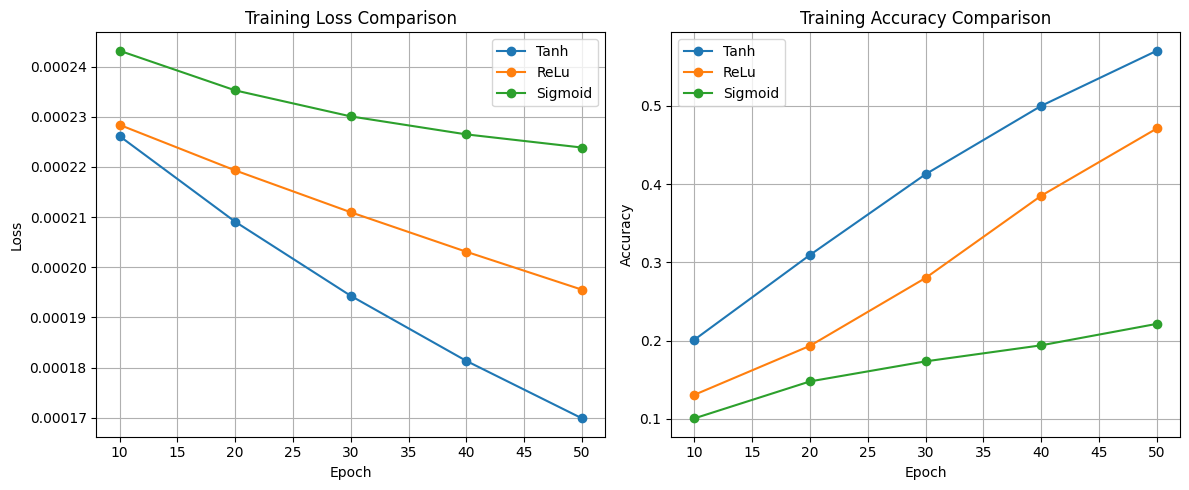

Tanh Test Accuracy: 52.70%
ReLu Test Accuracy: 39.90%
Sigmoid Test Accuracy: 21.90%


In [16]:
x_train, y_train, x_test, y_test = load_mnist_data()
x_train, y_train = x_train[:10000], y_train[:10000]
x_test, y_test = x_test[:2000], y_test[:2000]

activations = [Tanh, ReLu, Sigmoid]
results = {}

epochs = 50
verbose_interval = 10
learning_rate = 0.01

for act_class in activations:
    print(f"\nTraining with activation: {act_class.__name__}")

    layers = [
        FullyConnected(input_size=784, output_size=128, init_type=0),
        act_class(),
        FullyConnected(input_size=128, output_size=10, init_type=0),
        Softmax()
    ]

    network = Network(layers, learning_rate=learning_rate)
    loss = Loss(cross_entropy_loss, cross_entropy_loss_derivative)
    network.compile(loss)

    network.fit(x_train, y_train, epochs=epochs, learning_rate=learning_rate, verbose=verbose_interval)

    results[act_class.__name__] = {
        "losses": network.losses.copy(),
        "accuracies": network.accuracies.copy(),
        "epochs": network.epoch_list.copy(),
        "test_accuracy": network.accuracy(x_test, y_test)
    }

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for act_name, data in results.items():
    plt.plot(data["epochs"], data["losses"], marker='o', label=act_name)
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
for act_name, data in results.items():
    plt.plot(data["epochs"], data["accuracies"], marker='o', label=act_name)
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

for act_name, data in results.items():
    print(f"{act_name} Test Accuracy: {data['test_accuracy']*100:.2f}%")

## MNIST Training Example

In this example:

- We load and preprocess the MNIST dataset.  
- We take a smaller subset for faster training:
  - 10,000 training samples  
  - 2,000 test samples  
- The network architecture:
  1. Fully connected layer (784 → 128) + Tanh activation  
  2. Fully connected layer (128 → 10) + Softmax activation  
- We train the network for 100 epochs with learning rate 0.01.  
- We track training loss and compute test accuracy.


In [17]:
x_train, y_train, x_test, y_test = load_mnist_data()

x_train, y_train = x_train[:10000], y_train[:10000]
x_test, y_test = x_test[:2000], y_test[:2000]

layers = [
    FullyConnected(input_size=784, output_size=128, init_type=0),
    Tanh(),
    FullyConnected(input_size=128, output_size=10, init_type=0),
    Softmax()
]

network = Network(layers, learning_rate=0.01)
loss = Loss(cross_entropy_loss, cross_entropy_loss_derivative)
network.compile(loss)

verbose_interval = 10
epochs = 100
network.fit(x_train, y_train, epochs=epochs, learning_rate=0.01, verbose=verbose_interval)

losses_0 = network.losses.copy()
epochs_0 = network.epoch_list.copy()
accuracies_0 = network.accuracies.copy()

accuracy_0 = network.accuracy(x_test, y_test)

## Testing the Impact of Learning Rate on Neural Network Performance

In this experiment, we train a simple neural network on a reduced MNIST dataset, changing the **learning rate** to observe its effect on training speed and test accuracy.

### Data
- Training set: first 10,000 MNIST samples
- Test set: first 2,000 MNIST samples

### Network Architecture
1. Fully connected layer (`FullyConnected`) with 784 inputs and 128 neurons, weight initialization `init_type=0`
2. Activation function: `Tanh`
3. Fully connected layer with 128 inputs and 10 outputs
4. `Softmax` output layer

### Training Settings
- Number of epochs: 100
- Learning rate: **0.1** (increased compared to previous experiments)

In [18]:
x_train, y_train, x_test, y_test = load_mnist_data()

x_train, y_train = x_train[:10000], y_train[:10000]
x_test, y_test = x_test[:2000], y_test[:2000]

layers = [
  FullyConnected(input_size=784, output_size=128, init_type=0),
  Tanh(),
  FullyConnected(input_size=128, output_size=10, init_type=0),
  Softmax()
]

network = Network(layers, learning_rate=0.1)
loss = Loss(cross_entropy_loss, cross_entropy_loss_derivative)
network.compile(loss)
network.fit(x_train, y_train, epochs=100, learning_rate=0.1, verbose=10)

losses_1 = network.losses.copy()
epochs_1 = network.epoch_list.copy()
accuracies_1 = network.accuracies.copy()

accuracy_1 = network.accuracy(x_test, y_test)
print(f"Test Accuracy after training: {accuracy_1 * 100:.2f}%")

Test Accuracy after training: 85.00%


## Testing High Learning Rate (0.75) on Neural Network Training

In this experiment, we train the same simple neural network on a reduced MNIST dataset, but this time using a **high learning rate** to observe its impact on training stability and test accuracy.

### Data
- Training set: first 10,000 MNIST samples
- Test set: first 2,000 MNIST samples

### Network Architecture
1. Fully connected layer (`FullyConnected`) with 784 inputs and 128 neurons, weight initialization `init_type=0`
2. Activation function: `Tanh`
3. Fully connected layer with 128 inputs and 10 outputs
4. `Softmax` output layer

### Training Settings
- Number of epochs: 100
- Learning rate: **0.75** (significantly higher than previous experiments)
- Verbose: 10 (print progress every 10 epochs)

In [19]:
x_train, y_train, x_test, y_test = load_mnist_data()

x_train, y_train = x_train[:10000], y_train[:10000]
x_test, y_test = x_test[:2000], y_test[:2000]


layers = [
  FullyConnected(input_size=784, output_size=128, init_type=0),
  Tanh(),
  FullyConnected(input_size=128, output_size=10, init_type=0),
  Softmax()
]

network = Network(layers, learning_rate=0.75)
loss = Loss(cross_entropy_loss, cross_entropy_loss_derivative)
network.compile(loss)
network.fit(x_train, y_train, epochs=100, learning_rate=0.75, verbose=10)

losses_2 = network.losses.copy()
epochs_2 = network.epoch_list.copy()
accuracies_2 = network.accuracies.copy()

accuracy_2 = network.accuracy(x_test, y_test)
print(f"Test Accuracy after training: {accuracy_2 * 100:.2f}%")

Test Accuracy after training: 22.15%


## Comparing Different Learning Rates on Neural Network Training

In this experiment, we train the same simple neural network on a reduced MNIST dataset with **three different learning rates** to observe their effect on training stability and performance.

### Data
- Training set: first 10,000 MNIST samples
- Test set: first 2,000 MNIST samples

### Network Architecture
1. Fully connected layer (`FullyConnected`) with 784 inputs and 128 neurons, weight initialization `init_type=0`
2. Activation function: `Tanh`
3. Fully connected layer with 128 inputs and 10 outputs
4. `Softmax` output layer

### Training Settings
- Number of epochs: 100
- Learning rates tested: 0.01, 0.1, 0.75
- Verbose: 10 (print progress every 10 epochs)

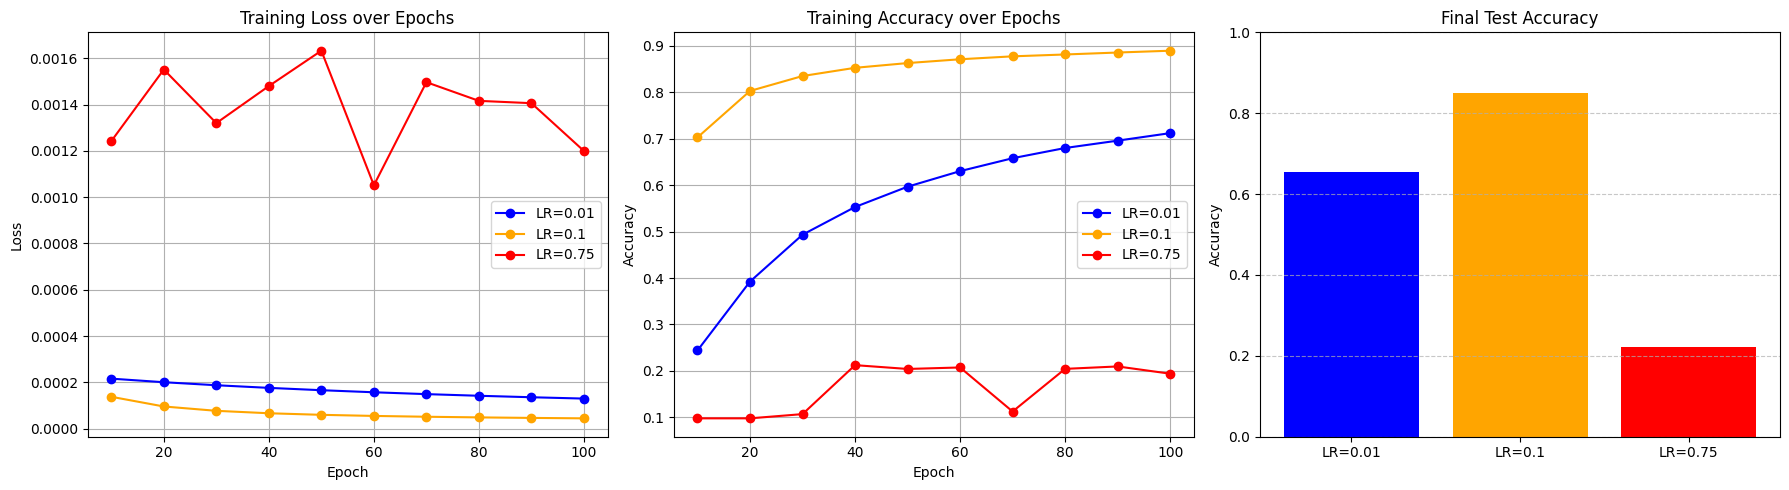

In [20]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(epochs_0, losses_0, marker='o', color='blue', label='LR=0.01')
plt.plot(epochs_1, losses_1, marker='o', color='orange', label='LR=0.1')
plt.plot(epochs_2, losses_2, marker='o', color='red', label='LR=0.75')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs_0, accuracies_0, marker='o', color='blue', label='LR=0.01')
plt.plot(epochs_1, accuracies_1, marker='o', color='orange', label='LR=0.1')
plt.plot(epochs_2, accuracies_2, marker='o', color='red', label='LR=0.75')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1,3,3)
final_accuracies = [accuracy_0, accuracy_1, accuracy_2]
learning_rates = ['LR=0.01', 'LR=0.1', 'LR=0.75']
colors = ['blue', 'orange', 'red']

plt.bar(learning_rates, final_accuracies, color=colors)
plt.ylim(0, 1)
plt.title("Final Test Accuracy")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Training a 4-Layer Neural Network on MNIST

In this experiment, we train a **4-layer fully connected neural network** on a reduced MNIST dataset to observe its performance and training dynamics.

### Data
- Training set: first 10,000 MNIST samples
- Test set: first 2,000 MNIST samples

### Network Architecture
1. Fully connected layer (`FullyConnected`) with 784 inputs and 512 neurons, weight initialization `init_type=0`
2. Activation: `Tanh`
3. Fully connected layer with 512 inputs and 256 outputs
4. Activation: `Tanh`
5. Fully connected layer with 256 inputs and 128 outputs
6. Activation: `Tanh`
7. Fully connected layer with 128 inputs and 64 outputs
8. Activation: `Tanh`
9. Fully connected layer with 64 inputs and 10 outputs
10. Output activation: `Softmax`

### Training Settings
- Number of epochs: 100
- Learning rate: 0.1
- Verbose: 10 (print progress every 10 epochs)

In [21]:
x_train, y_train, x_test, y_test = load_mnist_data()

x_train, y_train = x_train[:10000], y_train[:10000]
x_test, y_test = x_test[:2000], y_test[:2000]

layers = [
  FullyConnected(input_size=784, output_size=512, init_type=0),
  Tanh(),
  FullyConnected(input_size=512, output_size=256, init_type=0),
  Tanh(),
  FullyConnected(input_size=256, output_size=128, init_type=0),
  Tanh(),
  FullyConnected(input_size=128, output_size=64, init_type=0),
  Tanh(),
  FullyConnected(input_size=64, output_size=10, init_type=0),
  Softmax()
]

network = Network(layers, learning_rate=0.1)
loss = Loss(cross_entropy_loss, cross_entropy_loss_derivative)
network.compile(loss)
network.fit(x_train, y_train, epochs=100, learning_rate=0.1, verbose=10)

losses_4 = network.losses.copy()
epochs_4 = network.epoch_list.copy()
accuracies_4 = network.accuracies.copy()

accuracy_4 = network.accuracy(x_test, y_test)
print(f"Test Accuracy after training: {accuracy_4 * 100:.2f}%")

Test Accuracy after training: 87.85%


## Training a 7-Layer Neural Network on MNIST

In this experiment, we train a **7-layer fully connected neural network** on a reduced MNIST dataset to explore how adding more layers affects training and test accuracy.

### Data
- Training set: first 10,000 MNIST samples
- Test set: first 2,000 MNIST samples

### Network Architecture
1. Fully connected layer (`FullyConnected`) with 784 inputs and 512 neurons, weight initialization `init_type=0`
2. Activation: `Tanh`
3. Fully connected layer with 512 inputs and 256 outputs
4. Activation: `Tanh`
5. Fully connected layer with 256 inputs and 128 outputs
6. Activation: `Tanh`
7. Fully connected layer with 128 inputs and 64 outputs
8. Activation: `Tanh`
9. Fully connected layer with 64 inputs and 32 outputs
10. Activation: `Tanh`
11. Fully connected layer with 32 inputs and 16 outputs
12. Activation: `Tanh`
13. Fully connected layer with 16 inputs and 10 outputs
14. Output activation: `Softmax`

### Training Settings
- Number of epochs: 100
- Learning rate: 0.1
- Verbose: 10 (print progress every 10 epochs)

In [22]:
layers_7 = [
    FullyConnected(input_size=784, output_size=512, init_type=0),
    Tanh(),
    FullyConnected(input_size=512, output_size=256, init_type=0),
    Tanh(),
    FullyConnected(input_size=256, output_size=128, init_type=0),
    Tanh(),
    FullyConnected(input_size=128, output_size=64, init_type=0),
    Tanh(),
    FullyConnected(input_size=64, output_size=32, init_type=0),
    Tanh(),
    FullyConnected(input_size=32, output_size=16, init_type=0),
    Tanh(),
    FullyConnected(input_size=16, output_size=10, init_type=0),
    Softmax()
]

network_7 = Network(layers_7, learning_rate=0.1)
loss_7 = Loss(cross_entropy_loss, cross_entropy_loss_derivative)
network_7.compile(loss_7)
network_7.fit(x_train, y_train, epochs=100, learning_rate=0.1, verbose=10)

losses_7 = network_7.losses.copy()
epochs_7 = network_7.epoch_list.copy()
accuracies_7 = network_7.accuracies.copy()

accuracy_7 = network_7.accuracy(x_test, y_test)
print(f"Test Accuracy (7 layers) after training: {accuracy_7*100:.2f}%")


Test Accuracy (7 layers) after training: 85.80%


## Training a 10-Layer Neural Network on MNIST

In this experiment, we train a **10-layer fully connected neural network** on a reduced MNIST dataset to study how increasing depth affects training dynamics and test performance.

### Data
- Training set: first 10,000 MNIST samples
- Test set: first 2,000 MNIST samples

### Network Architecture
1. Fully connected layer (`FullyConnected`) with 784 inputs and 512 neurons, weight initialization `init_type=0`
2. Activation: `Tanh`
3. Fully connected layer with 512 inputs and 256 outputs
4. Activation: `Tanh`
5. Fully connected layer with 256 inputs and 128 outputs
6. Activation: `Tanh`
7. Fully connected layer with 128 inputs and 64 outputs
8. Activation: `Tanh`
9. Fully connected layer with 64 inputs and 32 outputs
10. Activation: `Tanh`
11. Fully connected layer with 32 inputs and 16 outputs
12. Activation: `Tanh`
13. Fully connected layer with 16 inputs and 16 outputs
14. Activation: `Tanh`
15. Fully connected layer with 16 inputs and 10 outputs
16. Output activation: `Softmax`

### Training Settings
- Number of epochs: 100
- Learning rate: 0.1
- Verbose: 10 (print progress every 10 epochs)


In [23]:
layers_10 = [
    FullyConnected(input_size=784, output_size=512, init_type=0),
    Tanh(),
    FullyConnected(input_size=512, output_size=256, init_type=0),
    Tanh(),
    FullyConnected(input_size=256, output_size=128, init_type=0),
    Tanh(),
    FullyConnected(input_size=128, output_size=64, init_type=0),
    Tanh(),
    FullyConnected(input_size=64, output_size=32, init_type=0),
    Tanh(),
    FullyConnected(input_size=32, output_size=16, init_type=0),
    Tanh(),
    FullyConnected(input_size=16, output_size=16, init_type=0),
    Tanh(),
    FullyConnected(input_size=16, output_size=10, init_type=0),
    Softmax()
]

network_10 = Network(layers_10, learning_rate=0.1)
loss_10 = Loss(cross_entropy_loss, cross_entropy_loss_derivative)
network_10.compile(loss_10)
network_10.fit(x_train, y_train, epochs=100, learning_rate=0.1, verbose=10)

losses_10 = network_10.losses.copy()
epochs_10 = network_10.epoch_list.copy()
accuracies_10 = network_10.accuracies.copy()

accuracy_10 = network_10.accuracy(x_test, y_test)
print(f"Test Accuracy (10 layers) after training: {accuracy_10*100:.2f}%")


Test Accuracy (10 layers) after training: 80.20%


## Comparing Neural Networks of Different Depths on MNIST

In this experiment, we compare **1-, 4-, 7-, and 10-layer fully connected neural networks** trained on a reduced MNIST dataset. The comparison focuses on **training loss, training accuracy, and final test accuracy** to understand how network depth affects learning and generalization.

### Data
- Training set: first 10,000 MNIST samples
- Test set: first 2,000 MNIST samples

### Network Architectures
- **1 Layer:** single hidden layer with 128 neurons  
- **4 Layers:** hidden layers with 512 → 256 → 128 → 64 neurons  
- **7 Layers:** hidden layers with 512 → 256 → 128 → 64 → 32 → 16 neurons  
- **10 Layers:** hidden layers with 512 → 256 → 128 → 64 → 32 → 16 → 16 neurons  
- Output layer: 10 neurons with `Softmax`

### Training Settings
- Number of epochs: 100  
- Learning rate: 0.1  
- Verbose: 10 (print progress every 10 epochs)

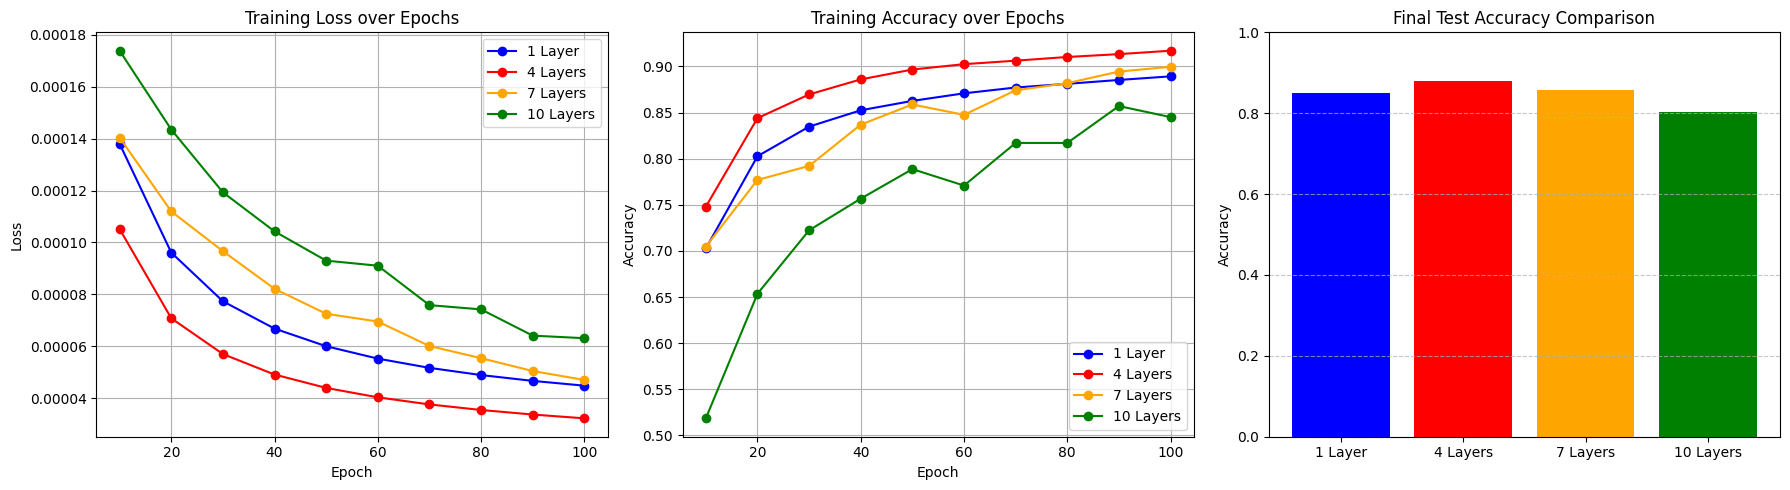

In [25]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(epochs_1, losses_1, marker='o', color='blue',
         label=f'1 Layer')
plt.plot(epochs_4, losses_4, marker='o', color='red',
         label=f'4 Layers')
plt.plot(epochs_7, losses_7, marker='o', color='orange',
         label=f'7 Layers')
plt.plot(epochs_10, losses_10, marker='o', color='green',
         label=f'10 Layers')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs_1, accuracies_1, marker='o', color='blue',
         label=f'1 Layer')
plt.plot(epochs_4, accuracies_4, marker='o', color='red',
         label=f'4 Layers')
plt.plot(epochs_7, accuracies_7, marker='o', color='orange',
         label=f'7 Layers')
plt.plot(epochs_10, accuracies_10, marker='o', color='green',
         label=f'10 Layers')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1,3,3)
final_accuracies = [accuracy_1, accuracy_4, accuracy_7, accuracy_10]
labels = ['1 Layer', '4 Layers', '7 Layers', '10 Layers']
colors = ['blue', 'red', 'orange', 'green']

plt.bar(labels, final_accuracies, color=colors)
plt.ylim(0,1)
plt.title("Final Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Effect of Number of Epochs on 1-Layer Neural Network (LR=0.1)

In this experiment, we explore how **the number of training epochs** affects the performance of a **1-layer fully connected neural network** on a reduced MNIST dataset.

### Data
- Training set: first 10,000 MNIST samples
- Test set: first 2,000 MNIST samples

### Network Architecture
- Input layer: 784 neurons  
- Hidden layer: 128 neurons, activation `Tanh`  
- Output layer: 10 neurons, activation `Softmax`  

### Training Settings
- Learning rate: 0.1  
- Number of epochs tested: 50, 100, 200, 400, 800  
- Verbose: 10 (print progress every 10 epochs)

Test Accuracy after 50 epochs: 83.25%
Test Accuracy after 100 epochs: 84.25%
Test Accuracy after 200 epochs: 86.60%
Test Accuracy after 400 epochs: 88.10%
Test Accuracy after 800 epochs: 89.40%


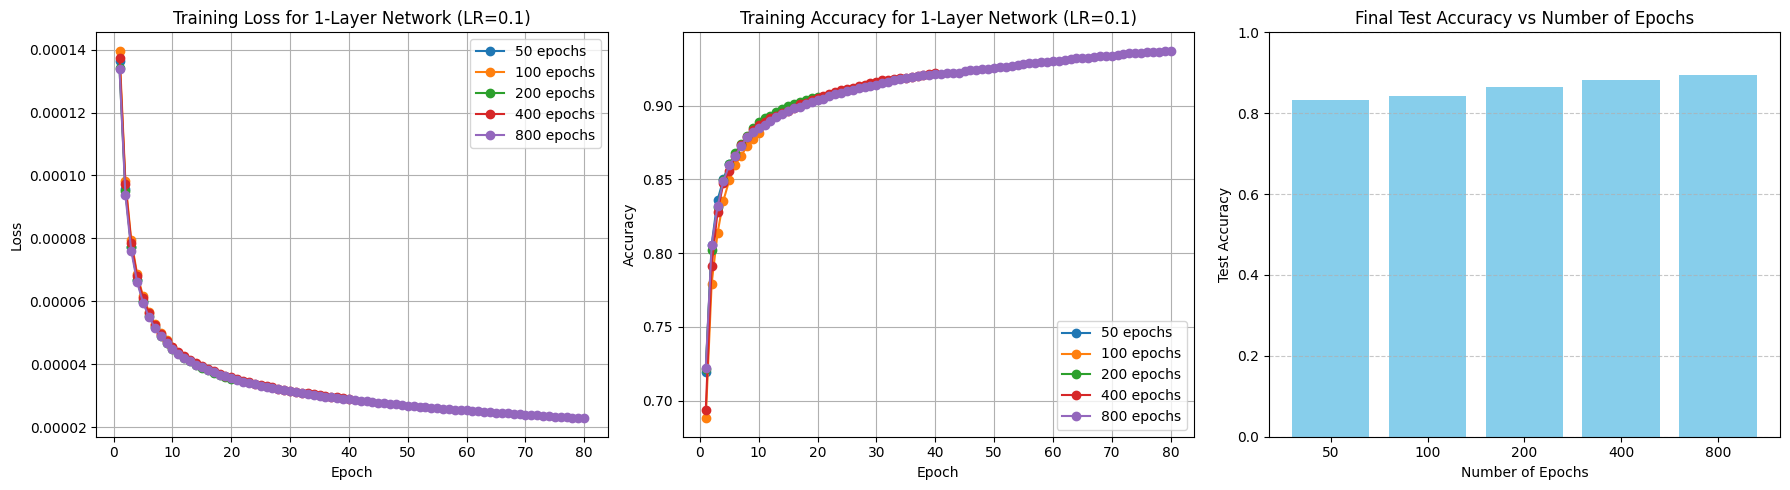

In [26]:
epoch_list = [50, 100, 200, 400, 800]

losses_dict = {}
accuracies_dict = {}
final_accuracies = {}

for epochs in epoch_list:
    layers = [
        FullyConnected(input_size=784, output_size=128, init_type=0),
        Tanh(),
        FullyConnected(input_size=128, output_size=10, init_type=0),
        Softmax()
    ]

    network = Network(layers, learning_rate=0.1)
    loss = Loss(cross_entropy_loss, cross_entropy_loss_derivative)
    network.compile(loss)

    network.fit(x_train, y_train, epochs=epochs, learning_rate=0.1, verbose=10)

    losses_dict[epochs] = network.losses.copy()
    accuracies_dict[epochs] = network.accuracies.copy()

    final_acc = network.accuracy(x_test, y_test)
    final_accuracies[epochs] = final_acc
    print(f"Test Accuracy after {epochs} epochs: {final_acc*100:.2f}%")

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
for epochs in epoch_list:
    plt.plot(range(1, len(losses_dict[epochs])+1), losses_dict[epochs],
             marker='o', label=f'{epochs} epochs')
plt.title("Training Loss for 1-Layer Network (LR=0.1)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,3,2)
for epochs in epoch_list:
    plt.plot(range(1, len(accuracies_dict[epochs])+1), accuracies_dict[epochs],
             marker='o', label=f'{epochs} epochs')
plt.title("Training Accuracy for 1-Layer Network (LR=0.1)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1,3,3)
plt.bar([str(e) for e in epoch_list],
        [final_accuracies[e] for e in epoch_list],
        color='skyblue')
plt.ylim(0,1)
plt.title("Final Test Accuracy vs Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Test Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Digit Recognition Demo

This interface allows you to draw a digit on the sketchpad and get a prediction from a simple neural network.

### Note
- The predictions may not be very accurate.  
- This is a very simple neural network trained on a limited dataset.  
- This demo is for basic digit recognition, so don't be surprised if the results are not perfect.


In [27]:
x_train, y_train, x_test, y_test = load_mnist_data()
x_train, y_train = x_train[:10000], y_train[:10000]
x_test, y_test = x_test[:2000], y_test[:2000]

layers = [
  FullyConnected(input_size=784, output_size=512, init_type=0),
  Tanh(),
  FullyConnected(input_size=512, output_size=256, init_type=0),
  Tanh(),
  FullyConnected(input_size=256, output_size=128, init_type=0),
  Tanh(),
  FullyConnected(input_size=128, output_size=64, init_type=0),
  Tanh(),
  FullyConnected(input_size=64, output_size=10, init_type=0),
  Softmax()
]

network = Network(layers, learning_rate=0.1)
loss = Loss(cross_entropy_loss, cross_entropy_loss_derivative)
network.compile(loss)
epochs = 500
network.fit(x_train, y_train, epochs=epochs, learning_rate=0.1, verbose=0)
test_accuracy = network.accuracy(x_test, y_test)
print(f"Test Accuracy after training: {test_accuracy*100:.2f}%")

Test Accuracy after training: 90.80%


In [28]:
from PIL import Image
import gradio as gr

img_size = 28
labels = list(range(10))
saved_x = None

def sketchToPrediction(img_dict):
  if img_dict is None:
    return {label: 0.0 for label in labels}

  global saved_x
  img_np = img_dict['composite']
  img = Image.fromarray(img_np).convert('L').resize((img_size, img_size))
  img = Image.eval(img, lambda x: 255 - x)
  x = np.array(img).reshape(1, 784) / 255.0
  saved_x = x
  y_pred = network(x)[0]
  return {label: float(prob) for label, prob in zip(labels, y_pred)}

iface = gr.Interface( fn=sketchToPrediction,
                      inputs=gr.Sketchpad(crop_size=(256, 256), type='numpy', image_mode='L'),
                      outputs=gr.Label(num_top_classes=3) )
iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6a33b5564c178bf0f2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
